# Stage 1: Exploratory Data Analysis

The objective is to take the first steps in the process of data exploration using SQL, Python3 with Numpy, Pandas and Matplotlib libraries.

I'll focus on analyzing some aspects of the real estate market of the City of Buenos Aires but for that I must first acquire the dataset from a BigQuery database.

# BigQuery data ingestion

To access the database I use an username provided by the companyto access the BigQuery database they have in Gcloud platform.
Once accessed the BigQuery database I do an exploratory analysis of the database composition.


## The database: Datapoints contain publication of properties for sale or rent with the property specifications and price. This database contains data from many Latam countries each one with their own table.


### Raw features of the ar_properties table are:

**id**: property id  
**start_date:** date of first publication  
**end_date:** end of publication  
**created_on:** date of publication creation  
**lat:** latitude of property location  
**lon:** longitude of property location  
**l1:** country  
**l2:** Province  
**l3:** City  
**l4:** Neighborhood  
**l5:** other location details  
**l6:** other location details  
**rooms:** how many total rooms  
**bedrooms:** how many bedrooms  
**bathrooms:** how many bathrooms  
**surface_total:** surface total in square meters  
**surface_covered:** surface covered in square meters (surface without counting balcony, courtyards and the likes)  
**price:** total price  
**currency:** currency in USD or ARS  
**price_period:** payment pediod if renting  
**title:** title of the publication  
**description:** description of the property  
**property_type:** property type  
**operation_type:** for sale or for rent  

For this project I will only use data from Argentina, more specificly from apartments in Buenos Aires City. For this purpouse I'm going to make a query filtering data to get only apartments from Buenos Aires City.


### The query:

Download the dataset as a .csv and load into this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import pandas_profiling

Also its important to import the rest of the libraries I'm going to use throughout this stage. Numpy to handle math functions and Pandas to handle Dataframes and Series. Then Matplotlib and Seaborn for visualization of the data. And pandas_profiling for a first glimpse of the data.  
Then some settings to make sure our data is easier to analyse

In [2]:
# I make sure all ploting happens inside the notebook
%matplotlib inline
# then I set the figures size for all my ploting
plt.rcParams['figure.figsize'] = (12,8)
# then I set the max number of columns Pandas will show if I call the dataset
pd.set_option('max_columns', 120)
pd.set_option('display.float_format', lambda x: '%.2f' % x) #toggle scientic notation

## Data Exploration

In [3]:
df = pd.read_csv('./Dataset.csv') #importing the dataset

In [4]:
report = pandas_profiling.ProfileReport(df)

C:\Users\ppmat\Anaconda3\lib\site-packages\pandas_profiling\model\correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 17).')
  correlation_name=correlation_name, error=error


In [5]:
report


# Handling the warnings of the profiling.

### Following the profiling report, many features won't give me much information.  I'll remove those columns to keep valuable features only.  
Features to be droped:
- Created_on: all dates are from 2019 and that's ok, no need to keep this column.  
- Features with constant values: l1, l2, property_type and operation_type. These values are constant because have been used as a filter in BigQuery. 
- l4, l5 and l6 have no data.  

In [6]:
df = df[['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency','ars_price']]


### It seems the Dataset contains many duplicate rows. Lets find out which ones and removed them if needed.

In [7]:
mask_dup = df.duplicated(keep=False)
duplicate_rows = df.loc[mask_dup, :]
duplicate_rows.head()

lat    lon            l3  rooms  bedrooms  bathrooms  surface_total  \
0  -34.58 -58.43       Palermo   1.00      0.00       1.00          21.00   
1  -34.65 -58.50     Mataderos   1.00      0.00       2.00          35.00   
2  -34.65 -58.50     Mataderos   1.00      0.00       2.00          35.00   
9  -34.58 -58.43       Palermo   1.00       nan       1.00          45.00   
11 -34.60 -58.44  Villa Crespo   1.00       nan       1.00         109.00   

    surface_covered    price currency  ars_price  
0               nan 75000.00      USD 4875000.00  
1             35.00 80000.00      USD 5200000.00  
2             35.00 80000.00      USD 5200000.00  
9             33.00     0.00      NaN       0.00  
11           109.00     0.00      NaN       0.00

Now I'll remove duplicates keeping the first row of each group.

In [8]:
df.drop_duplicates(keep='first', inplace=True)

Then I'll drop rows with missing data in important features which can't be calculated through any means, like total rooms or surface_covered or price

In [9]:
df.dropna(subset = ['rooms', 'surface_covered','price'], inplace=True)

Then I'll drop instances with value 0 in their price feature

In [10]:
df = df[df['price']!=0]

### ars_price feature:  some outliers and unreal values.


In [11]:
df.sort_values(by='ars_price', ascending=False).head() #.head for readability in github 

lat    lon         l3  rooms  bedrooms  bathrooms  surface_total  \
8878     nan    nan        NaN   2.00       nan       1.00            nan   
24709 -34.59 -58.39   Recoleta   6.00      3.00       3.00         600.00   
688   -34.59 -58.40   Recoleta   8.00      5.00       5.00         677.00   
26810 -34.59 -58.39   Recoleta  10.00      4.00       3.00         978.00   
6301  -34.61 -58.45  Caballito   1.00       nan       1.00          41.00   

       surface_covered       price currency    ars_price  
8878             49.00 12121212.00      USD 787878780.00  
24709           600.00  6000000.00      USD 390000000.00  
688             568.00  5800000.00      USD 377000000.00  
26810           489.00  5700000.00      USD 370500000.00  
6301             37.00  5112000.00      USD 332280000.00

An outlier for this feature is it's maximun value. And wrongly imputed currency in the min values of the feature. 
There are no apartments within those lower range prices, so I'm assuming the correct imput for the currency us USD and not ARS. 


Instances with false data like 12121212 or all 6s seem manually imputed as a filler. 

In [12]:
df.drop([8878], inplace=True) 

USD prices below 12000 are rare in Buenos Aires housing market and tend to be an imputing error. Better to drop them to reduce noice from the dataset. 

In [13]:
mask_price_drop = df['price']<12000
df.drop(df.index[mask_price_drop], inplace=True ) 

Same same logic but with ARS (USD12000*65=780000 minimun limit of amount in cases allowed)

In [14]:
mask_price_drop_ars= df['ars_price']<780000
df.drop(df.index[mask_price_drop_ars], inplace=True) 

Small apartments with exaggerated prices tend to be ARS prices inputed as USD prices. Remember ARS prices should be 65 times lower than USD prices.

In [15]:
mask_surfaceprice = (df['surface_total'] <100) & (df['currency'] == 'USD') & (df['price'] >3000000)
df.loc[mask_surfaceprice,'currency']='ARS' 

After replacing some USD values by ARS values I had to recalculate feature ars_price

In [16]:
df['ars_price'] = df.apply(lambda row: row['price']*65 if row['currency'] == 'USD' else row['price'], axis=1)


In [17]:
df.sort_values(by='ars_price', ascending=False).head()


lat    lon        l3  rooms  bedrooms  bathrooms  surface_total  \
24709 -34.59 -58.39  Recoleta   6.00      3.00       3.00         600.00   
688   -34.59 -58.40  Recoleta   8.00      5.00       5.00         677.00   
26810 -34.59 -58.39  Recoleta  10.00      4.00       3.00         978.00   
41083 -34.57 -58.42   Palermo   4.00       nan       4.00         404.00   
15160 -34.58 -58.43   Palermo   5.00      3.00       4.00         410.00   

       surface_covered      price currency    ars_price  
24709           600.00 6000000.00      USD 390000000.00  
688             568.00 5800000.00      USD 377000000.00  
26810           489.00 5700000.00      USD 370500000.00  
41083           404.00 5100000.00      USD 331500000.00  
15160           394.00 4900000.00      USD 318500000.00

In [18]:
df['ars_price'].describe()


count       36528.00
mean     16277011.50
std      19444842.08
min        780000.00
25%       7475000.00
50%      10585250.00
75%      17420000.00
max     390000000.00
Name: ars_price, dtype: float64

### Next feature to process is bathrooms with 5% missing data

In [19]:
bathrooms = df.loc[df['bathrooms'].isna(), :]
bathrooms.head()

lat    lon                l3  rooms  bedrooms  bathrooms  \
16  -34.60 -58.40               NaN   3.00       nan        nan   
117 -34.60 -58.50         Agronomía   1.00       nan        nan   
160 -34.60 -58.50  Villa del Parque   1.00       nan        nan   
172 -34.60 -58.38            Retiro   2.00      1.00        nan   
174 -34.61 -58.42           Almagro   2.00      1.00        nan   

     surface_total  surface_covered     price currency   ars_price  
16           73.00            73.00 230000.00      USD 14950000.00  
117          31.00            26.00  85000.00      USD  5525000.00  
160          32.00            28.00  85000.00      USD  5525000.00  
172          34.00            34.00 120000.00      USD  7800000.00  
174          26.00            26.00  72500.00      USD  4712500.00

In [20]:
df['bathrooms'].describe()

count   35359.00
mean        1.47
std         0.82
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        14.00
Name: bathrooms, dtype: float64

In [21]:
df['rooms'].describe()

count   36528.00
mean        2.62
std         1.26
min         1.00
25%         2.00
50%         3.00
75%         3.00
max        18.00
Name: rooms, dtype: float64

In [22]:
df.sort_values(by='bathrooms', ascending=False).head()

lat    lon          l3  rooms  bedrooms  bathrooms  surface_total  \
7429     nan    nan    Recoleta   2.00      1.00      14.00          45.00   
38155 -34.58 -58.42     Palermo   2.00      1.00      14.00          50.00   
4927  -34.58 -58.45  Colegiales   1.00       nan      14.00          40.00   
38043 -34.58 -58.41     Palermo   1.00       nan      14.00          37.00   
7346  -34.56 -58.46    Belgrano   1.00       nan      14.00          35.00   

       surface_covered     price currency   ars_price  
7429             45.00 159000.00      USD 10335000.00  
38155            50.00 225000.00      USD 14625000.00  
4927             40.00 140000.00      USD  9100000.00  
38043            37.00 150000.00      USD  9750000.00  
7346             32.00 120000.00      USD  7800000.00

There are many nan values wich I'll correct with passing a formula based on common sense knowledge about normal appartments.

In [23]:
df['bathrooms'] = df.apply(lambda row: (np.sqrt(row['rooms'])+1).astype(int) if np.isnan(row['bathrooms'])  else row['bathrooms'], axis=1)

There are some outliers where small apartments have too many bathrooms. Same formula will be applyed to cases where there are more bathrooms than rooms.

In [24]:
df['bathrooms'] = df.apply(lambda row: (np.sqrt(row['rooms'])+1).astype(int) if row['bathrooms']>row['rooms']  else row['bathrooms'], axis=1)

In [25]:
df.sort_values(by='bathrooms', ascending=False). head()

lat    lon            l3  rooms  bedrooms  bathrooms  surface_total  \
11227 -34.64 -58.53       Liniers  10.00     10.00      10.00         813.00   
15251 -34.60 -58.40      Recoleta  15.00       nan       9.00         700.00   
15248 -34.61 -58.38     Monserrat   9.00       nan       9.00         328.00   
56923 -34.65 -58.49  Villa Lugano   9.00       nan       9.00         400.00   
45777 -34.65 -58.47  Villa Lugano   9.00      9.00       9.00         400.00   

       surface_covered      price currency   ars_price  
11227           710.00 1200000.00      USD 78000000.00  
15251           550.00 1250000.00      USD 81250000.00  
15248           328.00  900000.00      USD 58500000.00  
56923           400.00  280000.00      USD 18200000.00  
45777           400.00  280000.00      USD 18200000.00

### Next feature to process is bedrooms. Highly skewed and 42% missing values.

In [26]:
df.sort_values(by='bedrooms', ascending=False).head()

lat    lon            l3  rooms  bedrooms  bathrooms  surface_total  \
35082 -34.62 -58.50  Monte Castro   3.00     21.00       1.00          82.00   
48304    nan    nan      Belgrano   2.00     12.00       1.00          56.00   
21726 -34.62 -58.37     San Telmo  15.00     12.00       7.00         540.00   
38507 -34.61 -58.44     Caballito   2.00     11.00       1.00          58.00   
11227 -34.64 -58.53       Liniers  10.00     10.00      10.00         813.00   

       surface_covered      price currency   ars_price  
35082            62.00  165000.00      USD 10725000.00  
48304            53.00  171000.00      USD 11115000.00  
21726           250.00  690000.00      USD 44850000.00  
38507            45.00  145000.00      USD  9425000.00  
11227           710.00 1200000.00      USD 78000000.00

I'll fill nan values and make sure there are no impossible values like more bedrooms than rooms

In [27]:
df['bedrooms'] = df.apply(lambda row: row['rooms'] if (np.isnan(row['bedrooms']))& (row['rooms']==1) else (  row['rooms']-1 if (np.isnan(row['bedrooms']))& (row['rooms']>1) else (  row['rooms']-1 if (row['bedrooms']>= row['rooms']) else row['bedrooms']) ) , axis=1)

In [28]:
df.sort_values(by='bedrooms', ascending=False).head()

lat    lon            l3  rooms  bedrooms  bathrooms  surface_total  \
43447 -34.63 -58.36          Boca  18.00     17.00       3.00         386.00   
15251 -34.60 -58.40      Recoleta  15.00     14.00       9.00         700.00   
21726 -34.62 -58.37     San Telmo  15.00     12.00       7.00         540.00   
35738 -34.62 -58.38     San Telmo  11.00     10.00       4.00         404.00   
7997  -34.60 -58.40  Barrio Norte  11.00     10.00       4.00         300.00   

       surface_covered      price currency   ars_price  
43447           323.00  240000.00      USD 15600000.00  
15251           550.00 1250000.00      USD 81250000.00  
21726           250.00  690000.00      USD 44850000.00  
35738           309.00  350000.00      USD 22750000.00  
7997            290.00  450000.00      USD 29250000.00

## Surface_total and surface_covered features

Surface total is not important when appraicing appartments, only covered surface is accounted. 

In [29]:
df.drop(['surface_total'], axis=1, inplace=True)

In [30]:
df['surface_covered'].isna().sum()

0

In [31]:
df['surface_covered'].describe()

count   36528.00
mean       77.00
std       188.32
min         1.00
25%        40.00
50%        55.00
75%        82.00
max     13857.00
Name: surface_covered, dtype: float64

Surface covered has issues too. Unreal min and max values.

In [32]:
df.sort_values(by='surface_covered', ascending=False).head()

lat    lon                 l3  rooms  bedrooms  bathrooms  \
773   -34.58 -58.43            Palermo   4.00      3.00       2.00   
8177  -34.61 -58.43  Parque Centenario   4.00      3.00       1.00   
52609 -34.59 -58.44            Palermo   3.00      2.00       2.00   
22836 -34.60 -58.47           Paternal   3.00      2.00       1.00   
54232 -34.59 -58.42            Palermo   3.00      2.00       2.00   

       surface_covered      price currency   ars_price  
773           13857.00 1250000.00      USD 81250000.00  
8177           8830.00  229000.00      USD 14885000.00  
52609          8080.00  380000.00      USD 24700000.00  
22836          8050.00  165000.00      USD 10725000.00  
54232          8000.00  350000.00      USD 22750000.00

In [33]:
df.sort_values(by='surface_covered', ascending=False).tail()

lat    lon             l3  rooms  bedrooms  bathrooms  \
47403 -34.63 -58.52      Versalles   3.00      2.00       1.00   
14364 -34.57 -58.48  Villa Urquiza   2.00      1.00       1.00   
28137 -34.62 -58.47         Flores   1.00      1.00       1.00   
27741 -34.57 -58.48  Villa Urquiza   5.00      4.00       5.00   
20998 -34.58 -58.47  Villa Urquiza   3.00      2.00       1.00   

       surface_covered     price currency   ars_price  
47403             1.00 115000.00      USD  7475000.00  
14364             1.00 129900.00      USD  8443500.00  
28137             1.00  95000.00      USD  6175000.00  
27741             1.00 628000.00      USD 40820000.00  
20998             1.00 136000.00      USD  8840000.00

There are some outliers with really high values which seem to be because of wrongly imputed decimals after fixing those I'm going to drop the outliers in the lower limit as I don't have a logic to imput values there.

In [34]:
df['surface_covered'] = df.apply(lambda row: row['surface_covered']/100 if row['surface_covered']>(row['rooms']*250) else row['surface_covered'], axis=1)

In [35]:
df = df[~(df['surface_covered']<12)]

I'm going to check if there are impossible values like instances where surface_covered values are bigger than surface_total values

In [36]:
df.sort_values(by='surface_covered', ascending=False).head()

lat    lon         l3  rooms  bedrooms  bathrooms  surface_covered  \
44503 -34.61 -58.38  Monserrat   5.00      4.00       1.00          1234.00   
46164 -34.60 -58.39   Recoleta   7.00      6.00       3.00           850.00   
11227 -34.64 -58.53    Liniers  10.00      9.00      10.00           710.00   
53593 -34.56 -58.45   Belgrano   6.00      4.00       3.00           656.00   
33031 -34.57 -58.44   Belgrano   7.00      6.00       5.00           600.00   

           price currency    ars_price  
44503  165000.00      USD  10725000.00  
46164 1400000.00      USD  91000000.00  
11227 1200000.00      USD  78000000.00  
53593 2500000.00      USD 162500000.00  
33031 2900000.00      USD 188500000.00

In [37]:
df.sort_values(by='surface_covered', ascending=False).tail()

lat    lon                l3  rooms  bedrooms  bathrooms  \
48949 -34.65 -58.42  Parque Patricios   1.00      0.00       1.00   
34950 -34.64 -58.51           Liniers   1.00      0.00       1.00   
54092 -34.63 -58.43         Caballito   3.00      2.00       2.00   
8791  -34.62 -58.38         San Telmo   1.00      0.00       2.00   
16371 -34.62 -58.45        Villa Luro   4.00      3.00       2.00   

       surface_covered     price currency  ars_price  
48949            14.00  31500.00      USD 2047500.00  
34950            13.00  12000.00      USD  780000.00  
54092            12.00 139000.00      USD 9035000.00  
8791             12.00  13000.00      USD  845000.00  
16371            12.00  24000.00      USD 1560000.00

In [38]:
df.drop(44503, axis=0, inplace=True)

## Lat, lon and l3 features

### One final task is needed to finish data prep. There are many localization (lat,lon) values missing and some l3 (neighborhood) missing to. I'll try to fill them by using localization or l3 to fill eachother.

In [39]:
neighborhood_lat = {}
neighborhood_lon = {}

for neighborhood in df['l3'].unique():
    neighborhood_lat[neighborhood] = df[((df['l3']==neighborhood) & (df['lat'].notnull()))].mean().lat
    neighborhood_lon[neighborhood] = df[((df['l3']==neighborhood) & (df['lon'].notnull()))].mean().lon
  

In [40]:
df['lat'] = df['lat'].fillna(df['l3'].map(neighborhood_lat))
df['lon'] = df['lon'].fillna(df['l3'].map(neighborhood_lon))

In [41]:
df[['lat','lon']].isna().sum() #this nan values come from l3 nan

lat    138
lon    138
dtype: int64

Since 138 are very few nan instances in l3 I'll drop them.

In [42]:
df = df[~df['l3'].isna()].rename(columns={'l3':'neighborhood'})

In [43]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36304 entries, 1 to 57917
Data columns (total 10 columns):
lat                36304 non-null float64
lon                36304 non-null float64
neighborhood       36304 non-null object
rooms              36304 non-null float64
bedrooms           36304 non-null float64
bathrooms          36304 non-null float64
surface_covered    36304 non-null float64
price              36304 non-null float64
currency           36304 non-null object
ars_price          36304 non-null float64
dtypes: float64(8), object(2)
memory usage: 3.0+ MB


## The dataset is cleaned. I'll run pandas Profiling again to see results

In [44]:
pandas_profiling.ProfileReport(df)


## After de data cleaning, surface covered and bedrooms are still highly correlated to surface total and rooms. I'm going to drop those features to avoid colinearity.  
## Also, since ars_price will be the target and it's a product of price and currency they'll be highly correlated so I'm going to drop them too.  
## Finally, only covered surface is computed for real estate appraisal, so total_surface will be droped too.

In [45]:
df['ars_m2'] = df['ars_price']/df['surface_covered']

In [46]:
df = df[['lat',	'lon',	'neighborhood',	'rooms','bathrooms','surface_covered','ars_price','ars_m2']]
df[['rooms','bathrooms','surface_covered','ars_price','ars_m2']] = df[['rooms','bathrooms','surface_covered','ars_price','ars_m2']].astype(int)

In [47]:
df = df[df['ars_m2']<1100000] #cleaning some more outliers

In [48]:
df.to_csv('./cleaned_dataset.csv', header=True, index=False)

# With a cleaned dataset I can start it's analysis.

### Firstly I'm going to compare neighborhoods ordered by their price in square meters.

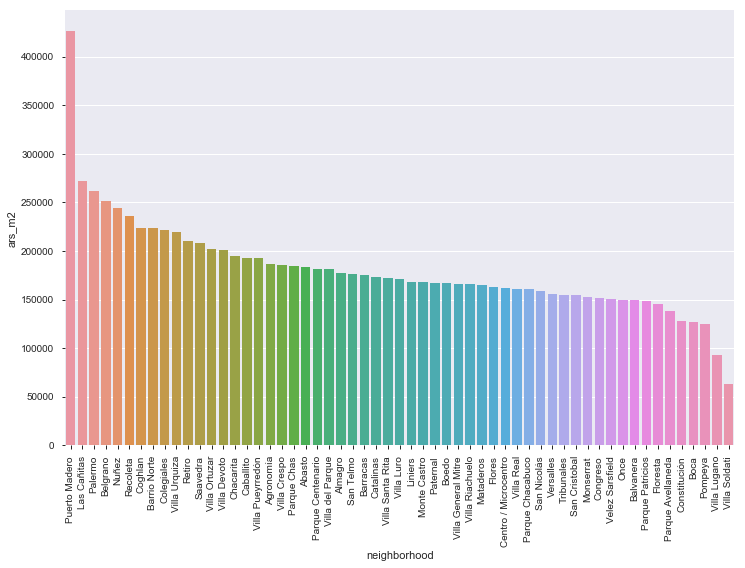

In [49]:
plt.xticks(rotation = 90)
hoods = df.groupby('neighborhood').mean().sort_values('ars_m2', ascending=False)
sns.barplot(x= hoods.index, y= hoods['ars_m2'], data=hoods)

### Clearly and by large margin Puerto Madero is the most expensive Neighborhood in town. Which is correct as it's a very young coastal development with hotels,  skyscrapers and other high end commercial ventures.  
### On the other end, popular and very old neighborhoods. Being Villa Soldati and Villa Lugano the southern and closest to de limits of the city. With Villa Soldati bordering a highly polluted river "El Riachuelo".

### Most expensive five

In [50]:
table = pd.pivot_table(df, values='ars_m2', index=['neighborhood'], aggfunc=np.mean).sort_values(by='ars_m2', ascending=False)
table.sort_values('ars_m2', ascending=False).iloc[:5]

ars_m2
neighborhood           
Puerto Madero 426226.40
Las Cañitas   272290.69
Palermo       261755.19
Belgrano      250909.09
Nuñez         243694.03

### Least expensive five

In [51]:
table.sort_values('ars_m2', ascending=True).iloc[:5]

ars_m2
neighborhood           
Villa Soldati  63052.90
Villa Lugano   92759.86
Pompeya       124951.89
Boca          126543.48
Constitución  127837.50

In [52]:
least_expensive_neighborhoods = table.iloc[-(len(table)//3):].sort_values(by='ars_m2',ascending=True)
mid_price_neighborhoods = table.iloc[(len(table)//3):(len(table)-(len(table)//3))]
most_expensive_neighborhoods = table.iloc[:(len(table)//3)]

## I'm going to plot some graphics to to try to figure some insights

### Surface of appartments

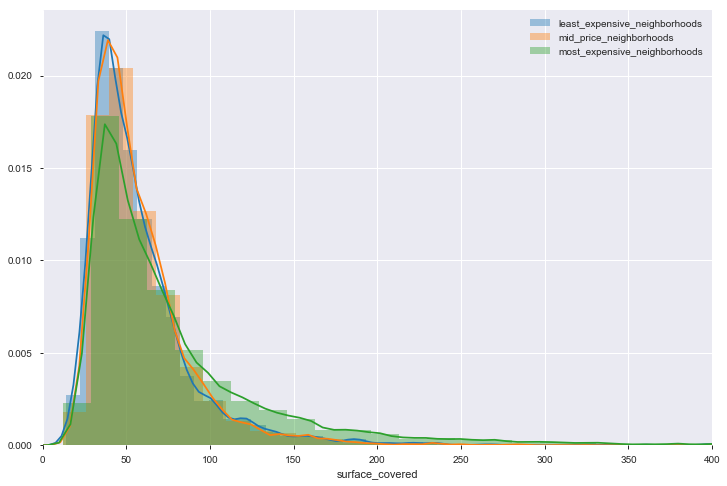

In [53]:
g = sns.distplot(df[df.neighborhood.isin(least_expensive_neighborhoods.index)].surface_covered, label="least_expensive_neighborhoods")
sns.distplot(df[df.neighborhood.isin(mid_price_neighborhoods.index)].surface_covered, label="mid_price_neighborhoods")
sns.distplot(df[df.neighborhood.isin(most_expensive_neighborhoods.index)].surface_covered, label="most_expensive_neighborhoods")
g.set_xlim(0, 400)
plt.legend()

In [54]:
df['surface_covered'].describe()

count   36291.00
mean       71.59
std        53.76
min        12.00
25%        40.00
50%        55.00
75%        81.00
max       850.00
Name: surface_covered, dtype: float64

In [55]:
df['surface_covered'].median()

55.0

In [56]:
df['surface_covered'].mode()

0    40
dtype: int32

The graphic above shows that most expensive neighborhoods have bigger appartments in general, but also shows an interesting point as both expensive and inexpensive neighborhoods have very high frequency (mode) on small appartments between 30 and 50 square, maintaining the trend of slightly bigger appartments on the high end prices.  
(Data is right skewed as mode and median is slightly to the left of mean)

### Number of rooms 

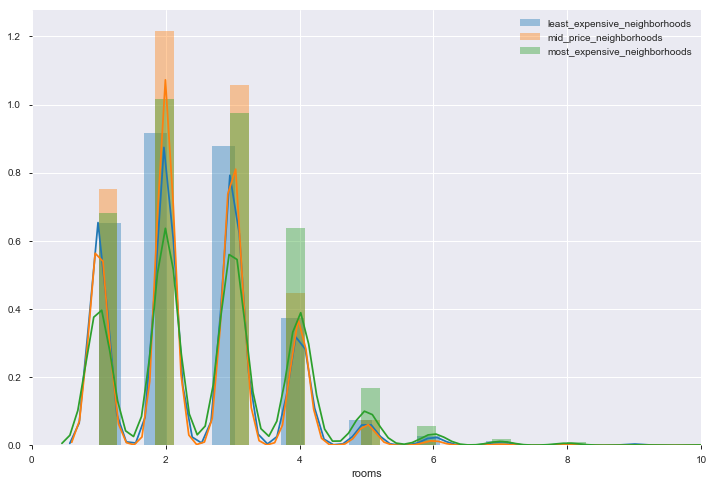

In [57]:
g = sns.distplot(df[df.neighborhood.isin(least_expensive_neighborhoods.index)].rooms, label="least_expensive_neighborhoods")
sns.distplot(df[df.neighborhood.isin(mid_price_neighborhoods.index)].rooms, label="mid_price_neighborhoods")
sns.distplot(df[df.neighborhood.isin(most_expensive_neighborhoods.index)].rooms, label="most_expensive_neighborhoods")
g.set_xlim(0, 10)
plt.legend()

In [58]:
df['rooms'].describe()

count   36291.00
mean        2.62
std         1.26
min         1.00
25%         2.00
50%         3.00
75%         3.00
max        18.00
Name: rooms, dtype: float64

In [59]:
df['rooms'].mode()

0    2
dtype: int32

As expected, expensive neighborhoods tend to have appartments with more rooms as its median sits around 3 against the other two groups (median 2). But in all three groups 2 rooms appartments are the most common occurrence (mode 2).

## Price per square meter

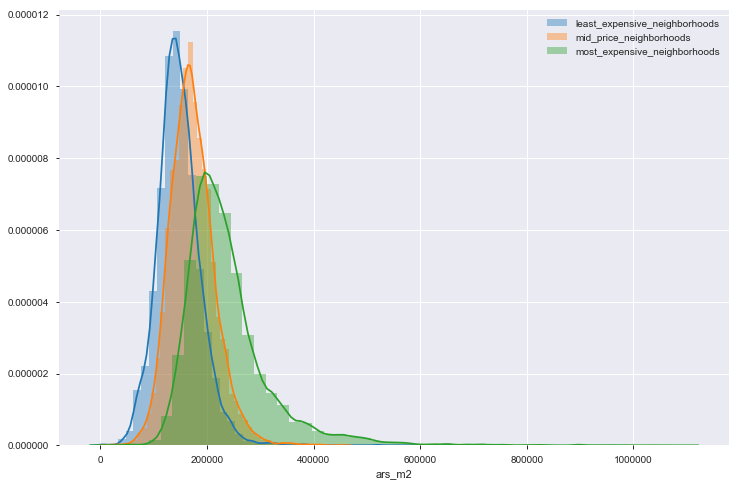

In [60]:
g = sns.distplot(df[df.neighborhood.isin(least_expensive_neighborhoods.index)].ars_m2, label="least_expensive_neighborhoods")
sns.distplot(df[df.neighborhood.isin(mid_price_neighborhoods.index)].ars_m2, label="mid_price_neighborhoods")
sns.distplot(df[df.neighborhood.isin(most_expensive_neighborhoods.index)].ars_m2, label="most_expensive_neighborhoods")
#g.set_xlim(0, 10)
plt.legend()